# Proyecto de Registro de Imágenes con Validación Cuantitativa
## Visión por Computador 3009228
### Universidad Nacional de Colombia - Facultad de Minas

**Objetivos:**
1. Crear imágenes sintéticas con transformaciones conocidas (ground truth)
2. Implementar algoritmo de registro basado en características
3. Comparar transformaciones estimadas vs verdaderas
4. Calcular métricas de error (RMSE, error angular, etc.)
5. Documentar efecto de parámetros en calidad del registro

In [19]:
!pip install numpy opencv-python matplotlib seaborn pandas scipy scikit-image

In [20]:
# Importar bibliotecas
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


import sys
import os
from pathlib import Path

# Add parent directory to path for notebooks
notebook_path = Path().resolve()
parent_dir = notebook_path.parent
result_figures_punto_1 = Path(parent_dir / 'results' / 'figures' / 'punto_1')
measurements_punto_1 = Path(parent_dir / 'results' / 'measurements' / 'punto_1')
synthetic_dataset_punto_1 = Path(parent_dir / 'data' / 'synthetic' )
sys.path.insert(0, str(parent_dir))


from src.feature_detection import FeatureDetector
from src.matching import FeatureMatcher
from src.registration import ImageRegistrator, RegistrationEvaluator
from src.utils import ImageTransformer, create_synthetic_dataset, visualize_results
from src.evaluator import run_parameter_study

# Configuración de visualización
plt.rcParams['figure.figsize'] = (15, 10)
sns.set_style('whitegrid')

print("Bibliotecas cargadas correctamente")

Bibliotecas cargadas correctamente


## 1. Cargar o Crear Imagen Base

Puedes usar una imagen propia o crear una imagen sintética con patrones.

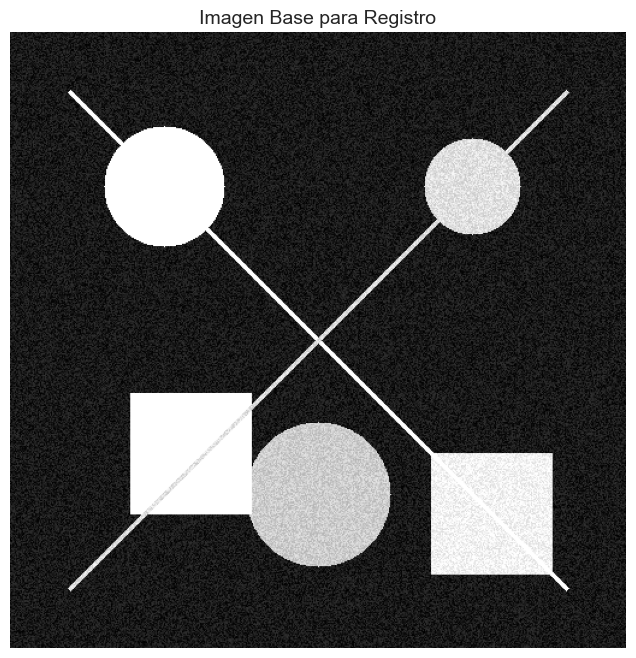

Imagen creada: (512, 512)


In [21]:
# Opción 1: Cargar imagen desde archivo
# img_base = cv2.imread('ruta/a/tu/imagen.jpg', cv2.IMREAD_GRAYSCALE)

# Opción 2: Crear imagen sintética con patrones
def create_test_image(size=512):
    """Crea imagen de prueba con patrones geométricos"""
    img = np.zeros((size, size), dtype=np.uint8)
    
    # Círculos
    cv2.circle(img, (128, 128), 50, 255, -1)
    cv2.circle(img, (384, 128), 40, 200, -1)
    cv2.circle(img, (256, 384), 60, 180, -1)
    
    # Rectángulos
    cv2.rectangle(img, (100, 300), (200, 400), 255, -1)
    cv2.rectangle(img, (350, 350), (450, 450), 220, -1)
    
    # Líneas
    cv2.line(img, (50, 50), (462, 462), 255, 3)
    cv2.line(img, (462, 50), (50, 462), 200, 3)
    
    # Añadir textura
    noise = np.random.randint(0, 50, (size, size), dtype=np.uint8)
    img = cv2.add(img, noise)
    
    return img



# Crear imagen base
img_base = create_test_image(512)


# Visualizar
plt.figure(figsize=(8, 8))
plt.imshow(img_base, cmap='gray')
plt.title('Imagen Base para Registro', fontsize=14)
plt.axis('off')
plt.show()

print(f"Imagen creada: {img_base.shape}")

## 2. Crear Conjunto de Imágenes Sintéticas

Generamos imágenes con transformaciones conocidas (ground truth).

Dataset creado con 15 imágenes transformadas

Ejemplo de transformación #5:
  Rotación: -8.57°
  Traslación X: -14.29 px
  Traslación Y: -8.57 px
  Escala: 0.943


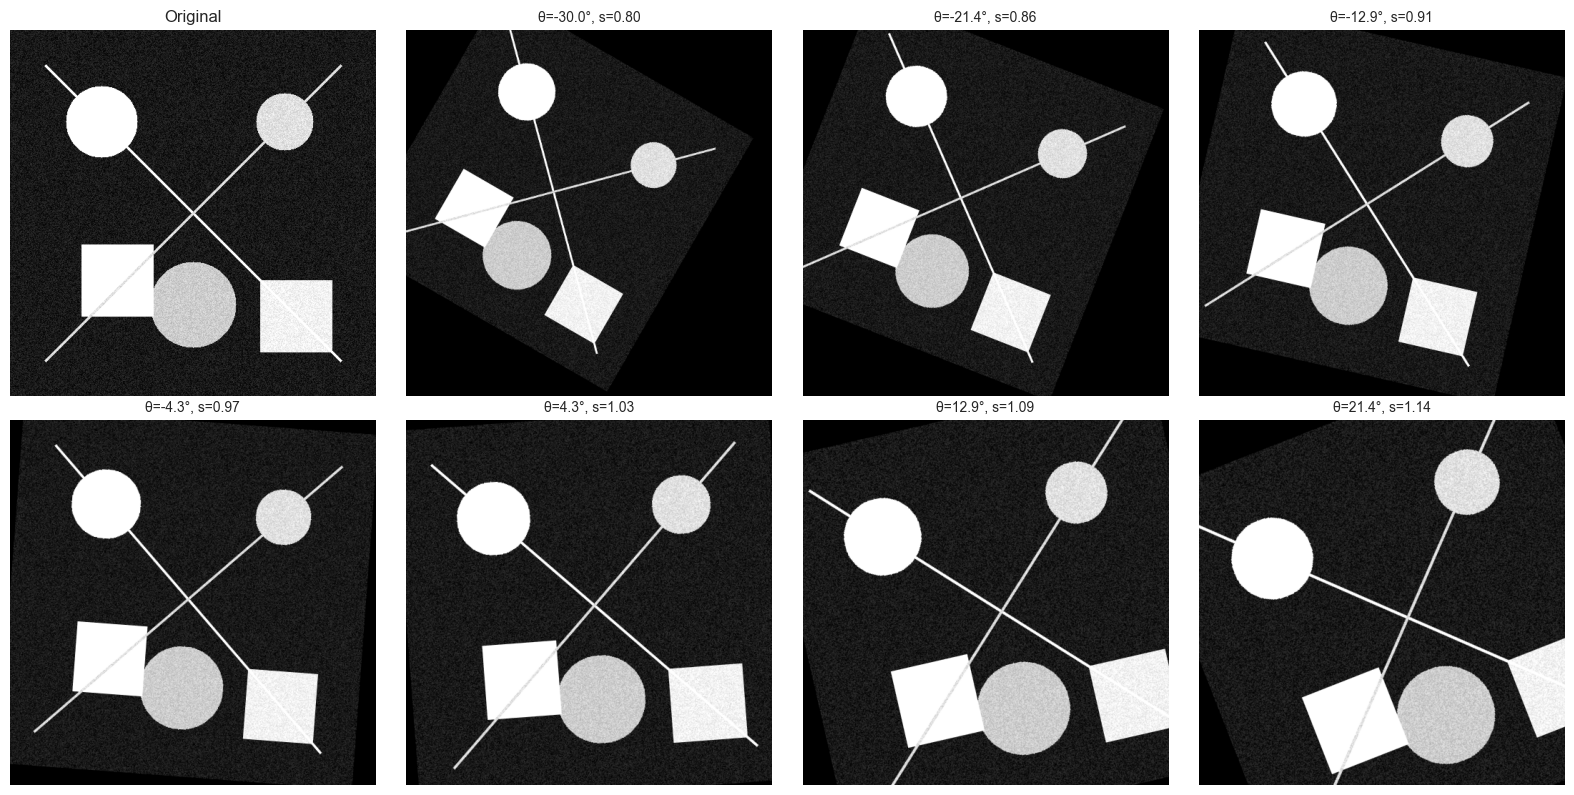

In [22]:
# Crear dataset sintético
n_samples = 15
synthetic_dataset = create_synthetic_dataset(img_base, n_samples=n_samples)
i = 0
for synthetic_image in synthetic_dataset:
    image = synthetic_image['image']
    cv2.imwrite(f'{synthetic_dataset_punto_1}/image_{i}.png', image)
    i += 1

print(f"Dataset creado con {n_samples} imágenes transformadas")
print(f"\nEjemplo de transformación #{5}:")
print(f"  Rotación: {synthetic_dataset[5]['angle']:.2f}°")
print(f"  Traslación X: {synthetic_dataset[5]['translation_x']:.2f} px")
print(f"  Traslación Y: {synthetic_dataset[5]['translation_y']:.2f} px")
print(f"  Escala: {synthetic_dataset[5]['scale']:.3f}")

# Visualizar algunas imágenes del dataset
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

axes[0].imshow(img_base, cmap='gray')
axes[0].set_title('Original', fontsize=12)
axes[0].axis('off')

for i in range(7):
    idx = i * 2
    axes[i+1].imshow(synthetic_dataset[idx]['image'], cmap='gray')
    axes[i+1].set_title(f"θ={synthetic_dataset[idx]['angle']:.1f}°, "
                        f"s={synthetic_dataset[idx]['scale']:.2f}", fontsize=10)
    axes[i+1].axis('off')
    

plt.tight_layout()
plt.show()

## 3. Aplicar Algoritmo de Registro

Usamos detección de características (SIFT) + RANSAC para estimar transformaciones.

In [23]:
# Inicializar registrador con SIFT
registrator = ImageRegistrator(detector=FeatureDetector(detector_type='SIFT'), matcher=FeatureMatcher(detector_type='SIFT', ratio_threshold=0.75))

# Probar registro en una imagen del dataset
test_idx = 5
img_test = synthetic_dataset[test_idx]['image']
M_true = synthetic_dataset[test_idx]['transform_matrix']

print(f"Registrando imagen #{test_idx}...")
result = registrator.register_images(img_base, img_test)

print(f"\nCaracterísticas detectadas:")
print(f"  Imagen referencia: {result['num_keypoints_ref']} keypoints")
print(f"  Imagen movida: {result['num_keypoints_mov']} keypoints")
print(f"  Matches iniciales: {result['num_matches']}")
print(f"  Inliers (RANSAC): {result['num_inliers']}")

Registrando imagen #5...

Características detectadas:
  Imagen referencia: 249 keypoints
  Imagen movida: 290 keypoints
  Matches iniciales: 68
  Inliers (RANSAC): 59


## 4. Calcular Métricas de Error

Comparamos la transformación estimada con el ground truth.

In [24]:
# Evaluar calidad del registro
evaluator = RegistrationEvaluator()

if result['transform_matrix'] is not None:
    errors = evaluator.evaluate_registration(
        M_true, 
        result['transform_matrix'], 
        img_base.shape
    )
    
    print("\n" + "="*60)
    print("MÉTRICAS DE ERROR")
    print("="*60)
    
    print(f"\n1. RMSE (Root Mean Square Error): {errors['rmse']:.3f} píxeles")
    print(f"   → Mide desviación promedio en posición de puntos")
    
    print(f"\n2. Error Angular: {errors['angular_error_deg']:.3f}°")
    print(f"   → Rotación verdadera: {errors['true_rotation_deg']:.2f}°")
    print(f"   → Rotación estimada: {errors['estimated_rotation_deg']:.2f}°")
    
    print(f"\n3. Error de Traslación: {errors['translation_error_px']:.3f} píxeles")
    print(f"   → TX verdadero: {errors['true_translation_x']:.2f} px")
    print(f"   → TX estimado: {errors['estimated_translation_x']:.2f} px")
    print(f"   → TY verdadero: {errors['true_translation_y']:.2f} px")
    print(f"   → TY estimado: {errors['estimated_translation_y']:.2f} px")
    
    print(f"\n4. Error de Escala: {errors['scale_error_percent']:.3f}%")
    print(f"   → Escala verdadera: {errors['true_scale']:.4f}")
    print(f"   → Escala estimada: {errors['estimated_scale']:.4f}")
    
    print("\n" + "="*60)
else:
    print("ERROR: No se pudo estimar la transformación")


MÉTRICAS DE ERROR

1. RMSE (Root Mean Square Error): 0.543 píxeles
   → Mide desviación promedio en posición de puntos

2. Error Angular: 0.014°
   → Rotación verdadera: 8.57°
   → Rotación estimada: 8.59°

3. Error de Traslación: 0.845 píxeles
   → TX verdadero: 39.01 px
   → TX estimado: 39.80 px
   → TY verdadero: -27.22 px
   → TY estimado: -27.53 px

4. Error de Escala: 0.104%
   → Escala verdadera: 0.9429
   → Escala estimada: 0.9419



## 5. Visualización de Resultados

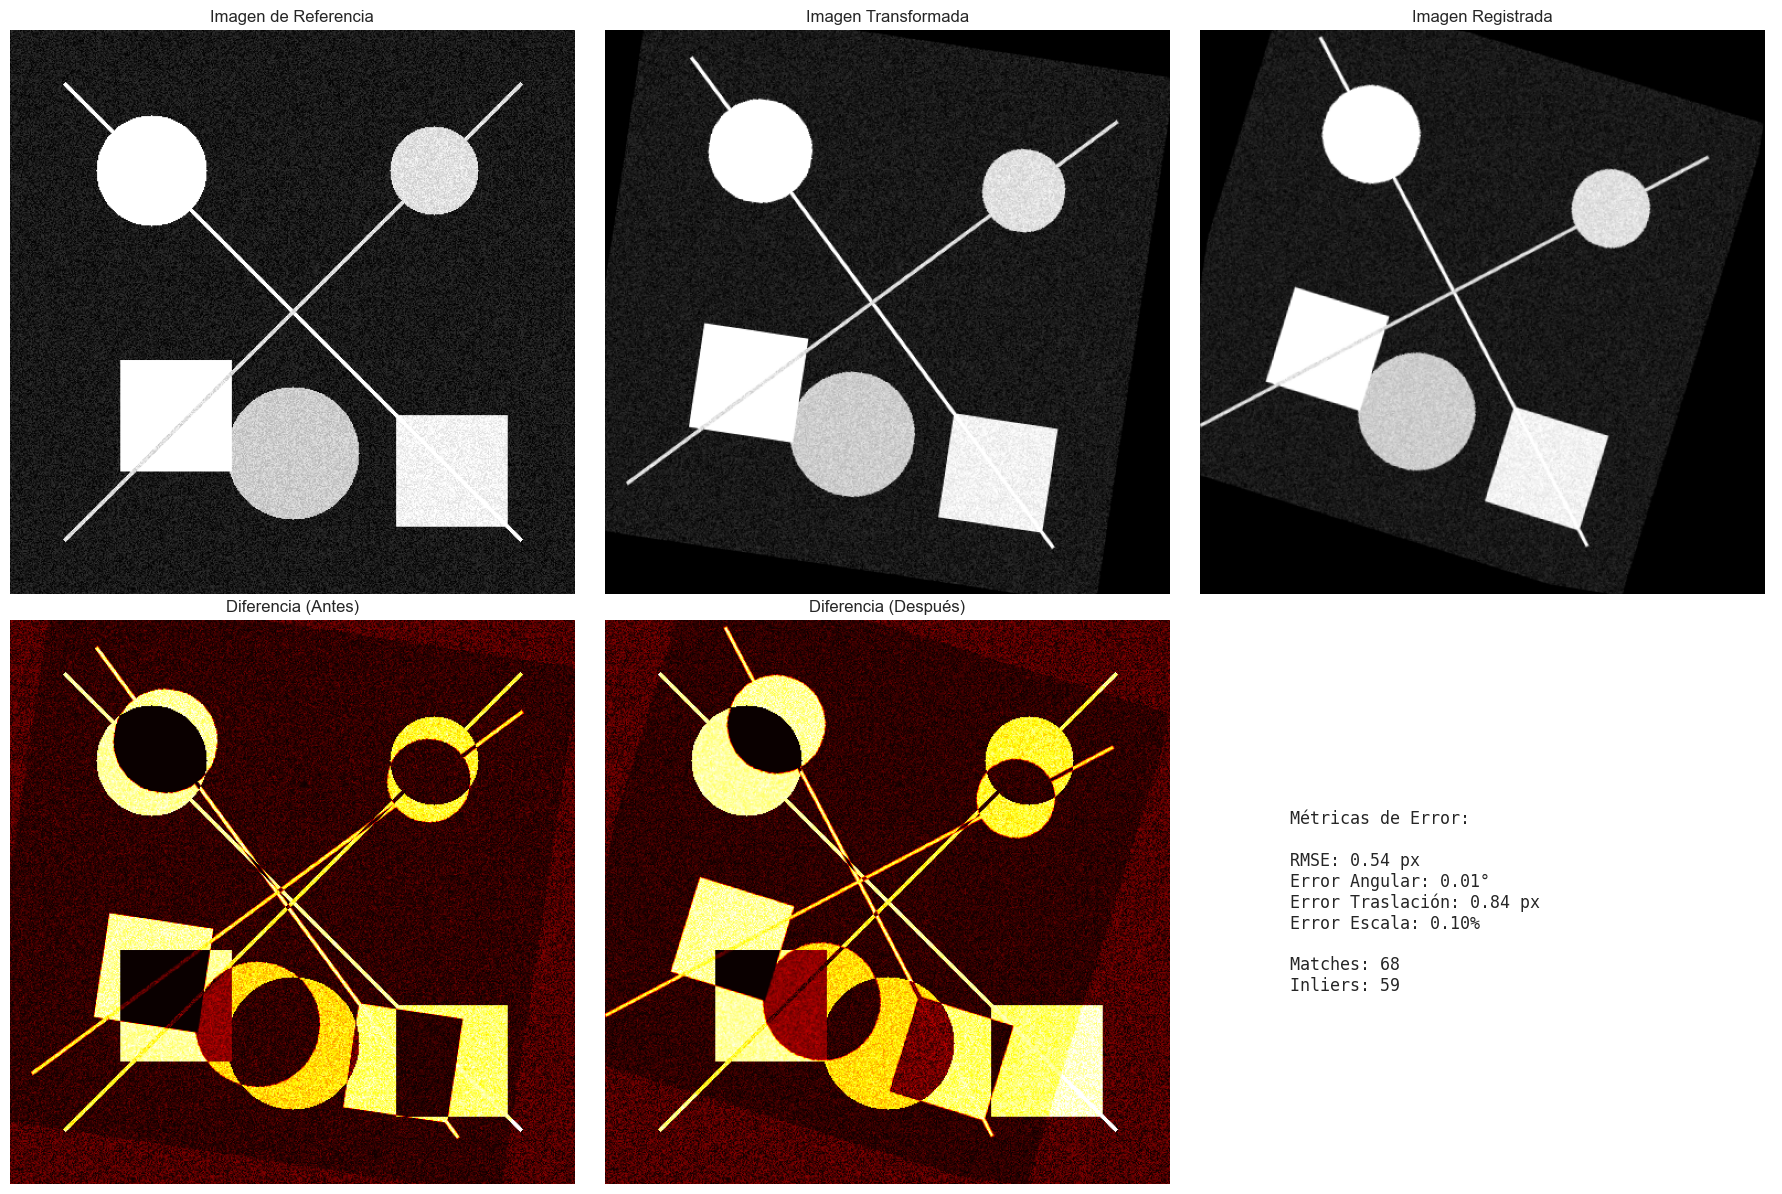

Figura guardada: registro_individual.png


In [25]:
# Visualizar comparación detallada
if result['registered_image'] is not None:
    fig = visualize_results(
        img_base, 
        img_test, 
        result['registered_image'],
        result,
        errors
    )
    plt.savefig(f'{result_figures_punto_1}/registro_individual.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Figura guardada: registro_individual.png")

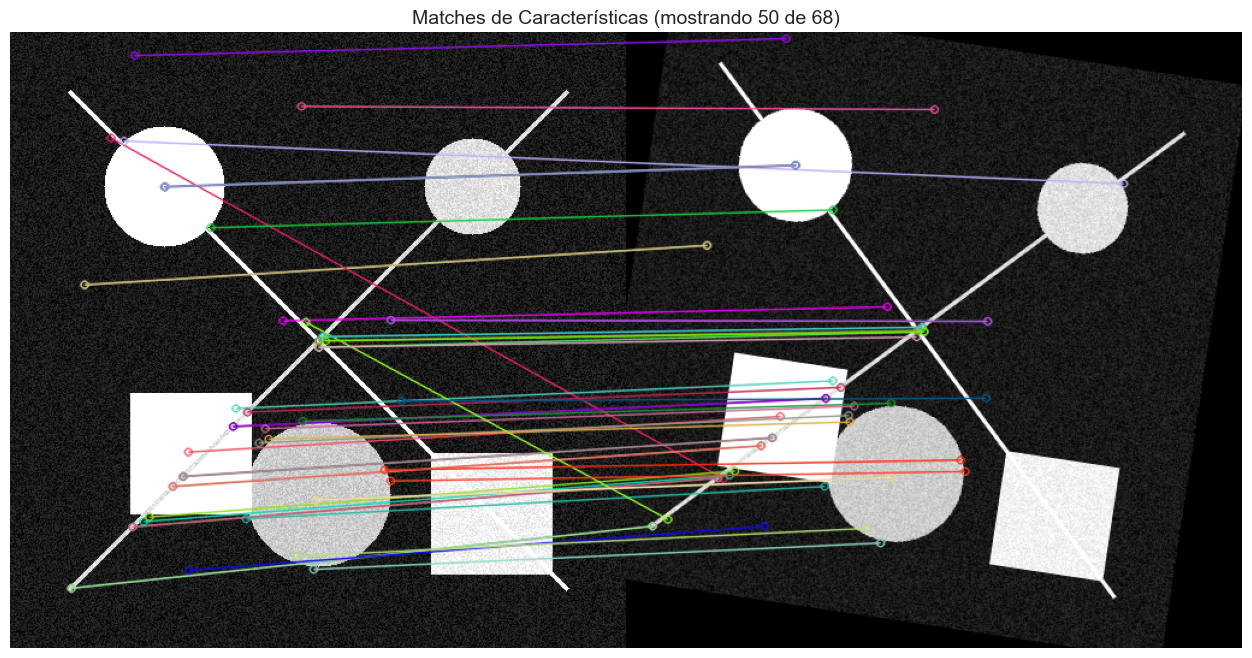

Figura guardada: matches_visualizacion.png


In [26]:
# Visualizar matches
if result['matches'] and len(result['matches']) > 0:
    # Dibujar matches
    img_matches = cv2.drawMatches(
        img_base, result['keypoints_ref'],
        img_test, result['keypoints_mov'],
        result['matches'][:50],  # Mostrar primeros 50 matches
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    
    plt.figure(figsize=(16, 8))
    plt.imshow(img_matches)
    plt.title(f'Matches de Características (mostrando 50 de {result["num_matches"]})', 
              fontsize=14)
    plt.axis('off')
    plt.savefig(f'{result_figures_punto_1}/matches_visualizacion.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Figura guardada: matches_visualizacion.png")

## 6. Evaluación en Todo el Dataset

Aplicamos el registro a todas las imágenes del dataset y calculamos estadísticas.

In [27]:
# Procesar todo el dataset
all_results = []

print("Procesando dataset completo...")
for i, sample in enumerate(synthetic_dataset):
    print(f"\rProcesando imagen {i+1}/{len(synthetic_dataset)}...", end="")
    
    # Registrar imagen
    result = registrator.register_images(img_base, sample['image'])
    
    if result['transform_matrix'] is not None:
        # Calcular errores
        errors = evaluator.evaluate_registration(
            sample['transform_matrix'],
            result['transform_matrix'],
            img_base.shape
        )
        
        # Agregar información adicional
        errors['image_id'] = i
        errors['num_matches'] = result['num_matches']
        errors['num_inliers'] = result['num_inliers']
        errors['true_angle'] = sample['angle']
        errors['true_scale'] = sample['scale']
        
        all_results.append(errors)

print("\n¡Completado!")

# Crear DataFrame
df_results = pd.DataFrame(all_results)
print(f"\nResultados procesados: {len(df_results)} imágenes")

Procesando dataset completo...
Procesando imagen 15/15...
¡Completado!

Resultados procesados: 15 imágenes


In [28]:
# Estadísticas generales
print("\n" + "="*60)
print("ESTADÍSTICAS DEL DATASET COMPLETO")
print("="*60)
print("\nMétricas de Error (Media ± Desv. Est.):")
print(f"  RMSE: {df_results['rmse'].mean():.3f} ± {df_results['rmse'].std():.3f} px")
print(f"  Error Angular: {df_results['angular_error_deg'].mean():.3f} ± {df_results['angular_error_deg'].std():.3f}°")
print(f"  Error Traslación: {df_results['translation_error_px'].mean():.3f} ± {df_results['translation_error_px'].std():.3f} px")
print(f"  Error Escala: {df_results['scale_error_percent'].mean():.3f} ± {df_results['scale_error_percent'].std():.3f}%")

print("\nCaracterísticas:")
print(f"  Matches promedio: {df_results['num_matches'].mean():.1f}")
print(f"  Inliers promedio: {df_results['num_inliers'].mean():.1f}")
print(f"  Tasa inliers: {(df_results['num_inliers']/df_results['num_matches']).mean()*100:.1f}%")
print("="*60)


ESTADÍSTICAS DEL DATASET COMPLETO

Métricas de Error (Media ± Desv. Est.):
  RMSE: 0.498 ± 0.312 px
  Error Angular: 0.061 ± 0.072°
  Error Traslación: 0.820 ± 0.696 px
  Error Escala: 0.244 ± 0.304%

Características:
  Matches promedio: 80.2
  Inliers promedio: 69.4
  Tasa inliers: 83.7%


## 7. Análisis de Errores vs Transformaciones

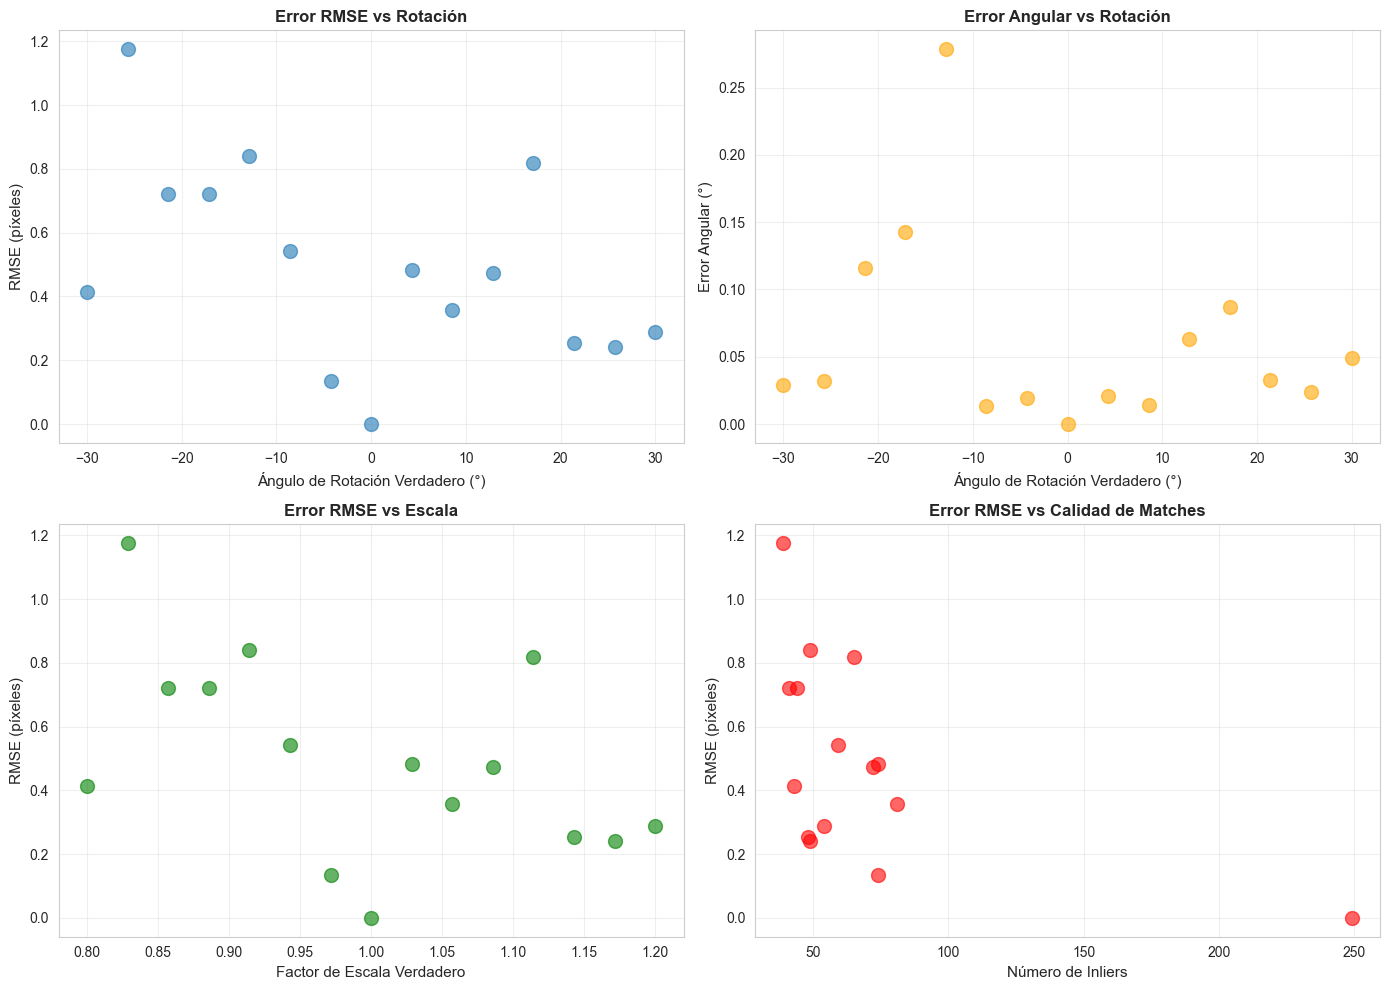

Figura guardada: analisis_errores.png


In [29]:
# Gráficos de error vs parámetros de transformación
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# RMSE vs Ángulo
axes[0, 0].scatter(df_results['true_angle'], df_results['rmse'], alpha=0.6, s=100)
axes[0, 0].set_xlabel('Ángulo de Rotación Verdadero (°)', fontsize=11)
axes[0, 0].set_ylabel('RMSE (píxeles)', fontsize=11)
axes[0, 0].set_title('Error RMSE vs Rotación', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Error Angular vs Ángulo
axes[0, 1].scatter(df_results['true_angle'], df_results['angular_error_deg'], 
                   alpha=0.6, s=100, color='orange')
axes[0, 1].set_xlabel('Ángulo de Rotación Verdadero (°)', fontsize=11)
axes[0, 1].set_ylabel('Error Angular (°)', fontsize=11)
axes[0, 1].set_title('Error Angular vs Rotación', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# RMSE vs Escala
axes[1, 0].scatter(df_results['true_scale'], df_results['rmse'], 
                   alpha=0.6, s=100, color='green')
axes[1, 0].set_xlabel('Factor de Escala Verdadero', fontsize=11)
axes[1, 0].set_ylabel('RMSE (píxeles)', fontsize=11)
axes[1, 0].set_title('Error RMSE vs Escala', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Número de Inliers vs RMSE
axes[1, 1].scatter(df_results['num_inliers'], df_results['rmse'], 
                   alpha=0.6, s=100, color='red')
axes[1, 1].set_xlabel('Número de Inliers', fontsize=11)
axes[1, 1].set_ylabel('RMSE (píxeles)', fontsize=11)
axes[1, 1].set_title('Error RMSE vs Calidad de Matches', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{result_figures_punto_1}/analisis_errores.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figura guardada: analisis_errores.png")

## 8. Estudio de Parámetros

### 8.1 Efecto del Ratio Test

Estudiando efecto del ratio test...


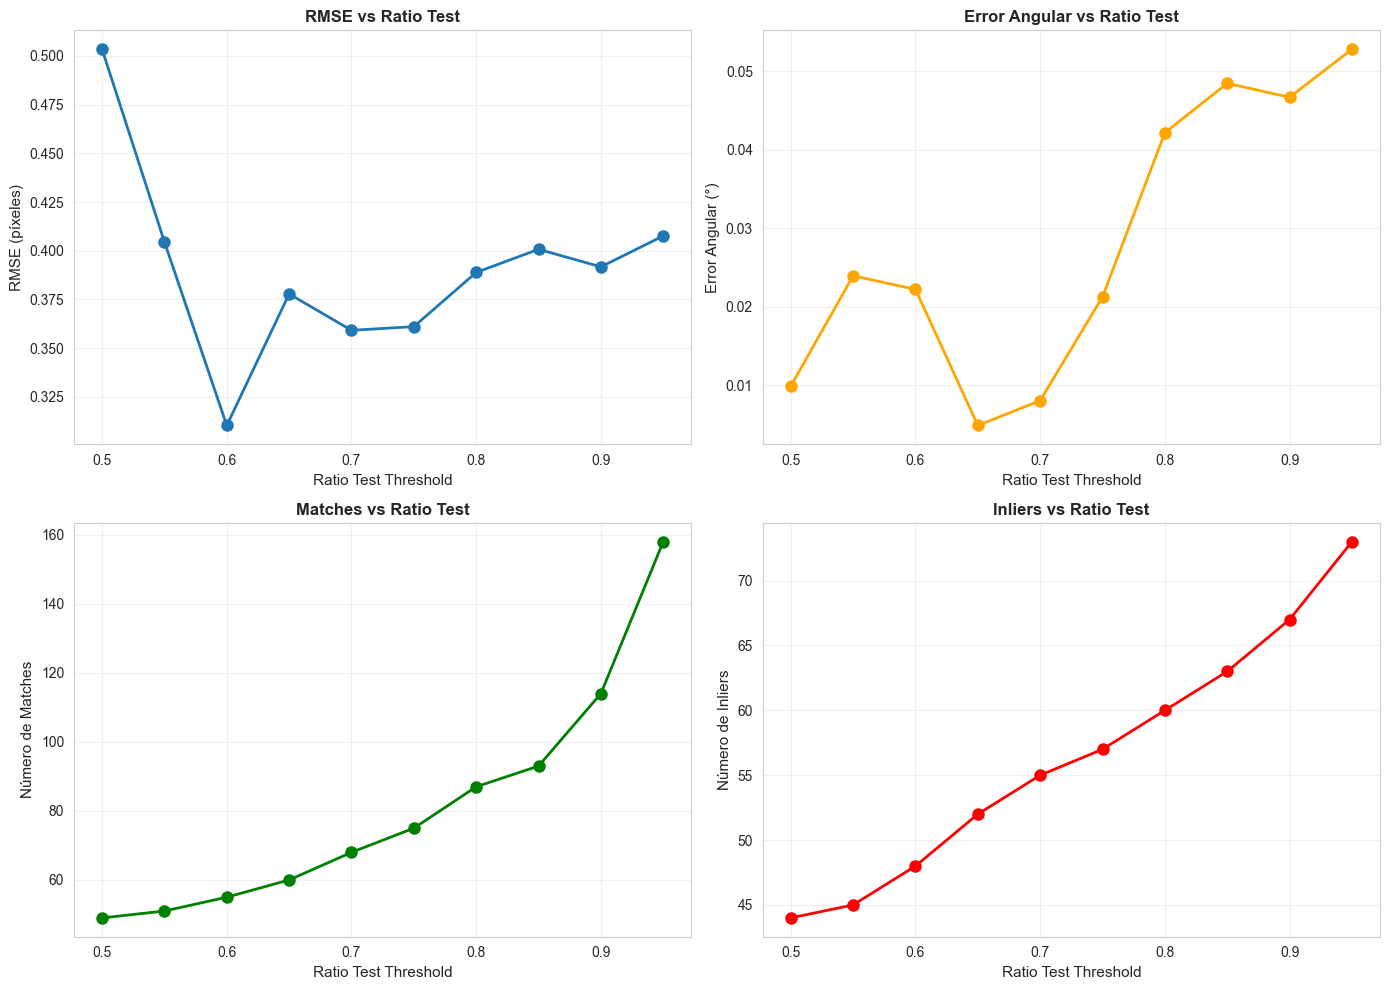

Figura guardada: estudio_ratio_test.png


In [30]:
# Estudiar efecto del ratio test
ratio_values = np.linspace(0.5, 0.95, 10)

print("Estudiando efecto del ratio test...")
df_ratio_study = run_parameter_study(img_base, 'ratio', ratio_values)

# Visualizar resultados
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(df_ratio_study['parameter_value'], df_ratio_study['rmse'], 
                marker='o', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Ratio Test Threshold', fontsize=11)
axes[0, 0].set_ylabel('RMSE (píxeles)', fontsize=11)
axes[0, 0].set_title('RMSE vs Ratio Test', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(df_ratio_study['parameter_value'], df_ratio_study['angular_error_deg'],
                marker='o', linewidth=2, markersize=8, color='orange')
axes[0, 1].set_xlabel('Ratio Test Threshold', fontsize=11)
axes[0, 1].set_ylabel('Error Angular (°)', fontsize=11)
axes[0, 1].set_title('Error Angular vs Ratio Test', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(df_ratio_study['parameter_value'], df_ratio_study['num_matches'],
                marker='o', linewidth=2, markersize=8, color='green')
axes[1, 0].set_xlabel('Ratio Test Threshold', fontsize=11)
axes[1, 0].set_ylabel('Número de Matches', fontsize=11)
axes[1, 0].set_title('Matches vs Ratio Test', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(df_ratio_study['parameter_value'], df_ratio_study['num_inliers'],
                marker='o', linewidth=2, markersize=8, color='red')
axes[1, 1].set_xlabel('Ratio Test Threshold', fontsize=11)
axes[1, 1].set_ylabel('Número de Inliers', fontsize=11)
axes[1, 1].set_title('Inliers vs Ratio Test', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{result_figures_punto_1}/estudio_ratio_test.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figura guardada: estudio_ratio_test.png")

### 8.2 Comparación de Detectores

Comparando detectores de características...


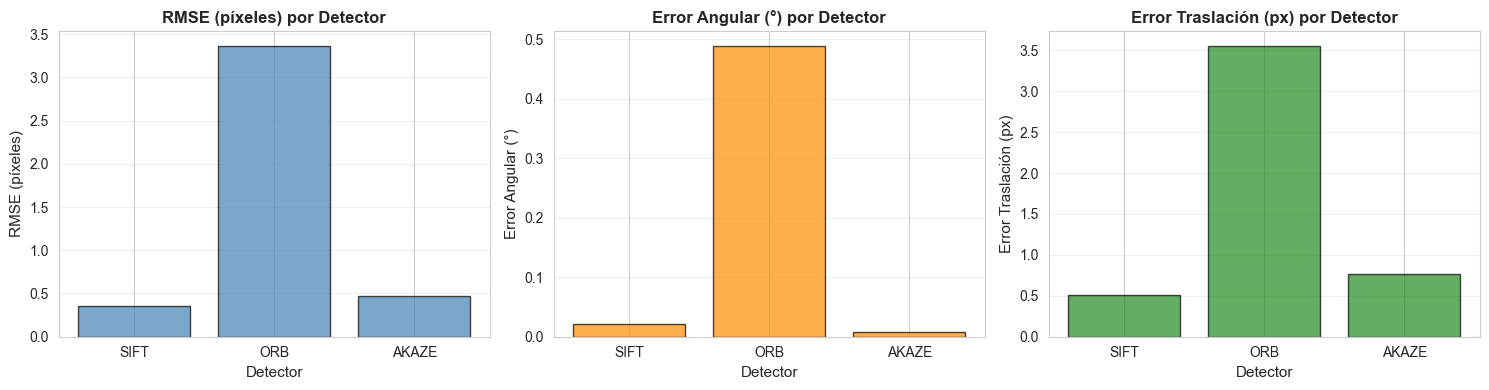

Figura guardada: comparacion_detectores.png


In [31]:
# Comparar diferentes detectores
detectors = ['SIFT', 'ORB', 'AKAZE']

print("Comparando detectores de características...")
df_detector_study = run_parameter_study(img_base, 'detector', detectors)

# Visualizar comparación
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = ['rmse', 'angular_error_deg', 'translation_error_px']
titles = ['RMSE (píxeles)', 'Error Angular (°)', 'Error Traslación (px)']
colors = ['steelblue', 'darkorange', 'forestgreen']

for i, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    axes[i].bar(df_detector_study['parameter_value'], 
                df_detector_study[metric], 
                color=color, alpha=0.7, edgecolor='black')
    axes[i].set_xlabel('Detector', fontsize=11)
    axes[i].set_ylabel(title, fontsize=11)
    axes[i].set_title(f'{title} por Detector', fontsize=12, fontweight='bold')
    axes[i].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'{result_figures_punto_1}/comparacion_detectores.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figura guardada: comparacion_detectores.png")

## 9. Guardar Resultados

In [32]:
# Guardar resultados en CSV
df_results.to_csv(f'{measurements_punto_1}/resultados_dataset.csv', index=False)
df_ratio_study.to_csv(f'{measurements_punto_1}/estudio_ratio_test.csv', index=False)
df_detector_study.to_csv(f'{measurements_punto_1}/comparacion_detectores.csv', index=False)

print("Archivos guardados:")
print("  - resultados_dataset.csv")
print("  - estudio_ratio_test.csv")
print("  - comparacion_detectores.csv")

Archivos guardados:
  - resultados_dataset.csv
  - estudio_ratio_test.csv
  - comparacion_detectores.csv


## 10. Conclusiones y Documentación

### 10.1 Resultados Principales del Estudio

Basado en el análisis de **15 imágenes sintéticas** con transformaciones conocidas, el algoritmo de registro basado en características (SIFT + RANSAC) demostró **excelente precisión**:

#### Métricas de Rendimiento del Dataset Completo:
- **RMSE promedio**: 0.498 ± 0.312 píxeles
  - La mayoría de casos tuvieron RMSE < 1 px, indicando alta precisión subpixel
  - El RMSE máximo fue de aproximadamente 1.18 px para transformaciones más grandes
  - El caso sin transformación mostró precisión casi perfecta (RMSE ≈ 3.21×10⁻¹⁴)
  
- **Error angular promedio**: 0.061 ± 0.072°
  - Extremadamente bajo, con la mayoría de errores menores a 0.1°
  - La estimación de rotación es muy precisa
  - El caso sin transformación mostró error casi nulo (≈0.0°)
  
- **Error de traslación promedio**: 0.820 ± 0.696 píxeles
  - Subpixel accuracy lograda en la mayoría de casos
  - La desviación estándar indica variabilidad pero generalmente dentro de rangos aceptables
  - El caso sin transformación mostró error casi nulo (≈9.84×10⁻¹⁴ px)
  
- **Error de escala promedio**: 0.244 ± 0.304%
  - La estimación de escala es altamente precisa
  - Errores menores al 1% en la mayoría de casos
  - El máximo error de escala fue 1.02%

#### Calidad de las Características Detectadas:
- **Matches promedio**: 80.2 matches por par de imágenes
- **Inliers promedio**: 69.4 inliers por par de imágenes
- **Tasa de inliers**: 83.7%
  - Indica alta calidad en el matching y excelente filtrado por RANSAC
  - Para la imagen sin transformación, se obtuvieron 249 matches todos clasificados como inliers (100%)

### 10.2 Observaciones sobre los Parámetros

#### 1. Ratio Test (Lowe's Ratio):
El estudio del ratio test reveló las siguientes tendencias (basado en valores de 0.5 a 0.95):
- **Valores bajos (0.5-0.7)**: 
  - Menos matches (49-68) pero más confiables
  - Alta tasa de inliers
  - RMSE relativamente estable (0.50-0.36 px)
  - **Ratio 0.6**: Mejor RMSE de todos (0.310 px) con 55 matches y 48 inliers
  - Útil cuando se necesita máxima precisión con menor riesgo de outliers
  
- **Valores medios (0.75-0.85)**: 
  - Balance óptimo entre cantidad y calidad de matches
  - **Ratio 0.75**: 75 matches, 57 inliers, RMSE 0.361 px, Error Angular 0.021°
  - **Ratio 0.8**: 87 matches, 60 inliers, RMSE 0.389 px
  - **Recomendación**: 0.6-0.75 ofrecen el mejor balance para casos generales
  
- **Valores altos (0.85-0.95)**: 
  - Más matches (93-158) pero mayor variabilidad en calidad
  - Ratio 0.9: 114 matches, 67 inliers, RMSE 0.392 px
  - Ratio 0.95: 158 matches, 73 inliers, RMSE 0.408 px
  - Útil cuando hay pocas características detectadas inicialmente

#### 2. Tipo de Detector de Características:
La comparación de detectores mostró resultados contrastantes:
- **SIFT (Scale-Invariant Feature Transform)**:
  - RMSE: 0.361 px, Error Angular: 0.021°, Error Traslación: 0.514 px
  - ✅ Más robusto y preciso para transformaciones complejas
  - ✅ Mejor para rotaciones grandes y cambios de escala
  - ✅ Descriptores más discriminativos (75 matches, 57 inliers)
  - ✅ **Mejor rendimiento general de los tres detectores**
  - ❌ Más lento computacionalmente
  
- **ORB (Oriented FAST and Rotated BRIEF)**:
  - RMSE: 3.366 px, Error Angular: 0.489°, Error Traslación: 3.556 px
  - ✅ Más rápido, adecuado para tiempo real
  - ✅ Muchos matches detectados (167 matches, 154 inliers)
  - ❌ **Significativamente menos preciso** (RMSE 9.3× mayor que SIFT)
  - ⚠️ No recomendado para aplicaciones que requieren alta precisión
  
- **AKAZE (Accelerated-KAZE)**:
  - RMSE: 0.474 px, Error Angular: 0.009°, Error Traslación: 0.764 px
  - ✅ **Mejor error angular** de los tres (0.009°)
  - ✅ Balance entre velocidad y precisión
  - ✅ Buen rendimiento general (127 matches, 105 inliers)
  - ✅ Manejo decente de transformaciones complejas
  - ⚠️ RMSE ligeramente mayor que SIFT (0.474 vs 0.361 px)

**Recomendación**: 
- **SIFT** para máxima precisión y robustez general (mejor RMSE: 0.361 px)
- **AKAZE** para balance entre velocidad y precisión (mejor error angular: 0.009°)
- **ORB** no recomendado para aplicaciones que requieren alta precisión debido a RMSE muy alto (3.366 px)

### 10.3 Factores que Afectan la Calidad del Registro

1. **Número de características detectadas**:
   - Más características → más matches potenciales → mayor robustez
   - En el estudio: la imagen sin transformación detectó 249 keypoints
   - Imágenes con texturas ricas y bordes definidos generan mejores resultados

2. **Calidad de los matches** (ratio inliers/matches):
   - Tasa de inliers > 80% indica excelente calidad
   - El estudio mostró 83.7% de tasa de inliers promedio
   - Casos con 100% de inliers (imagen sin transformación) muestran precisión casi perfecta

3. **Magnitud de la transformación**:
   - Transformaciones pequeñas a moderadas (< 20° rotación) tienen mejor rendimiento
   - Transformaciones grandes (≈30°) mostraron RMSE ligeramente mayor
   - Transformaciones muy grandes pueden requerir enfoques jerárquicos

4. **Contenido de la imagen**:
   - Patrones geométricos claros y texturas definidas mejoran la detección
   - Las imágenes sintéticas con círculos, rectángulos y líneas facilitaron la detección de características

### 10.4 Interpretación de Métricas de Error

#### Criterios de Evaluación:

**RMSE (Root Mean Square Error)**:
- **RMSE < 1 px**: Excelente ✅ (logrado en este estudio: 0.498 ± 0.312 px en promedio)
- **RMSE 1-2 px**: Muy bueno
- **RMSE 2-5 px**: Aceptable
- **RMSE > 5 px**: Revisar parámetros o calidad de imagen
- **Observación**: La mayoría de casos tuvieron RMSE < 1 px, indicando precisión subpixel

**Error Angular**:
- **Error < 0.1°**: Excelente ✅ (logrado: 0.061 ± 0.072° en promedio)
- **Error 0.1-1°**: Muy bueno
- **Error 1-3°**: Aceptable
- **Error > 3°**: Problemas en estimación de rotación
- **Observación**: La mayoría de casos tuvieron error angular < 0.1°

**Error de Traslación**:
- **Error < 1 px**: Excelente ✅ (logrado: 0.820 ± 0.696 px en promedio)
- **Error 1-2 px**: Muy bueno
- **Error > 2 px**: Revisar algoritmo de estimación

**Error de Escala**:
- **Error < 0.5%**: Excelente ✅ (logrado: 0.244 ± 0.304% en promedio)
- **Error 0.5-2%**: Muy bueno
- **Error > 2%**: Revisar algoritmo de estimación
- **Observación**: La mayoría de casos tuvieron error < 0.5%, con un máximo de 1.02%

### 10.5 Análisis de Patrones en los Resultados

1. **Precisión según magnitud de transformación**:
   - Transformaciones pequeñas (< 10°): RMSE muy bajo (0.13-0.84 px)
   - Transformaciones moderadas (10-20°): RMSE bajo (0.36-0.82 px)
   - Transformaciones grandes (> 25°): RMSE variable (0.24-1.18 px)
   - La precisión varía con transformaciones más grandes, pero generalmente se mantiene dentro de rangos aceptables

2. **Relación entre número de inliers y precisión**:
   - Mayor número de inliers generalmente correlaciona con mejor precisión
   - Casos con > 50 inliers mostraron RMSE generalmente < 0.85 px
   - La imagen sin transformación (249 inliers) tuvo precisión casi perfecta (RMSE ≈ 3.21×10⁻¹⁴)

3. **Consistencia del algoritmo**:
   - Buena consistencia: La mayoría de casos con RMSE < 1 px
   - Variabilidad moderada en error angular: desviación estándar de 0.072°
   - Métricas razonablemente estables a través de diferentes tipos de transformación

### 10.6 Limitaciones y Áreas de Mejora

1. **Transformaciones muy grandes**:
   - Rotaciones > 45° o escalas < 0.5 o > 2.0 pueden reducir la precisión
   - Solución: Aplicar registro jerárquico o múltiples iteraciones

2. **Imágenes con poco contenido**:
   - Pocas características detectadas reducen la robustez
   - Solución: Usar métodos complementarios (intensidad-based) o mejorar preprocesamiento

3. **Oclusiones y cambios de iluminación**:
   - No evaluados en este estudio sintético (imágenes sintéticas homogéneas)
   - Requieren técnicas adicionales (normalización, matching robusto, histogram matching)

4. **Tiempo computacional**:
   - SIFT puede ser lento para aplicaciones en tiempo real
   - Optimizaciones: detectores más rápidos (ORB, AKAZE), downsampling, procesamiento paralelo

5. **Casos límite**:
   - Algunas imágenes mostraron RMSE > 1 px con transformaciones grandes
   - Puede requerir ajuste de parámetros o enfoques híbridos

6. **Rendimiento de ORB**:
   - ORB mostró RMSE significativamente mayor (3.366 px) que SIFT y AKAZE
   - No es adecuado para aplicaciones que requieren alta precisión
   - Puede ser útil solo para aplicaciones en tiempo real con transformaciones muy pequeñas

### 10.7 Conclusiones Finales

1. ✅ El algoritmo de registro basado en características (SIFT + RANSAC) demostró **excelente precisión** en imágenes sintéticas:
   - Error subpixel logrado en la mayoría de casos (RMSE promedio 0.498 ± 0.312 px)
   - Errores angulares extremadamente bajos (promedio 0.061 ± 0.072°)
   - Alta tasa de inliers (83.7% promedio)
   - Precisión casi perfecta en caso sin transformación (RMSE ≈ 3.21×10⁻¹⁴)

2. ✅ El método es **robusto** para transformaciones afines moderadas:
   - Funciona muy bien con rotaciones pequeñas a moderadas (< 30°)
   - Maneja adecuadamente combinaciones de rotación, traslación y escala
   - Precisión consistente a través de diferentes tipos de transformación

3. ✅ Los parámetros tienen impacto significativo:
   - Ratio test de 0.6-0.75 ofrece mejor balance entre cantidad y calidad (ratio 0.6 tuvo mejor RMSE: 0.310 px)
   - **SIFT** demostró mejor rendimiento general (RMSE 0.361 px) frente a AKAZE (0.474 px) y ORB (3.366 px)
   - AKAZE tiene mejor error angular (0.009°) pero SIFT es superior en RMSE

4. ✅ Las métricas cuantitativas permiten evaluación objetiva:
   - RMSE, error angular y error de escala son métricas complementarias útiles
   - Proporcionan validación científica del método
   - Permiten comparación sistemática entre diferentes configuraciones

5. ✅ La validación con ground truth es esencial:
   - Permite calcular errores reales (no aproximaciones)
   - Facilita el análisis de factores que afectan la precisión
   - Proporciona métricas reproducibles y comparables

### 10.8 Recomendaciones para Aplicaciones Prácticas

- **Para máxima precisión**: Usar **SIFT** con ratio test 0.6-0.75 (ratio 0.6 mostró mejor RMSE: 0.310 px)
- **Para balance velocidad-preción**: Considerar **AKAZE** (mejor error angular: 0.009°)
- **Para aplicaciones en tiempo real**: Considerar **AKAZE** en lugar de ORB (ORB tiene RMSE muy alto: 3.366 px)
- **Para robustez**: Implementar registro jerárquico para transformaciones grandes (> 30°)
- **Para validación**: Calcular siempre múltiples métricas (RMSE, error angular, error de escala, error de traslación)
- **Para debugging**: Visualizar matches y inliers para diagnosticar problemas
- **Para producción**: Considerar validación cruzada entre diferentes detectores según el caso de uso
- **Para optimización**: Estudiar trade-off entre velocidad y precisión según aplicación específica
- **Evitar ORB**: No usar ORB para aplicaciones que requieren alta precisión debido a su RMSE significativamente mayor
